## Background:

We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.

Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.

## Data Description:

You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.

## Goal:

Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.

## Success Metrics:

Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.


## Project Description

Time series data was decomposed to analyze it and SARIMAX model was used on each of the stocks. The model was trained on data from 2020 and predicted prices in 2021. These predictions were tested against real data by application of Bollinger bands strategy. Using machine learning strategy resulted in addictional return which is higher than just buying and holding strategy. Comparisons of incremental returns in first quarter of 2021 are given in table below:


| Stock | Return if BUY & HOLD | Return with Machine Learning Strategy |
|:--------:|:--------:|:--------:|
|Sberbank Rossii PAO|6.99%|8.16%|
|Koc Holding AS|-8.44%|14.5%|
|Medinet Nasr Housing|-2.09%|0%|
|Minerva SABrazil|1.59%|16.24%|
|Pampa Energia SA|11.02%|24.37%|
|Cementos Argos SA|-15.57%|0%|
|Impala Platinum|26.56%|35%|
|Dongkuk Steel Mil|57.26%|10.84%|



### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

# Import seasonal decomposition and kpss from statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler


plt.rcParams['figure.figsize'] = (16, 9)
style.use('ggplot')

### Loading the data

In [2]:
# Read Excel file into dictionary where each item is a sheet of spreadsheet
dic_df = pd.read_excel('datasets/2020Q1Q2Q3Q4-2021Q1.xls', 
                       sheet_name = None, 
                       parse_dates=['Date'], 
                       index_col = 'Date', 
                       skipfooter=1)

### Explore the data
First I need to check the dictionary with dataframes and their values.

In [3]:
# Print length of the dictionary and first sheet name
print(f'Excel spreadsheet has {len(dic_df.keys())} sheets')
print(f'First sheet is named: {list(dic_df.keys())[0]}')

Excel spreadsheet has 8 sheets
First sheet is named: Russia - Sberbank Rossii PAO (S


So dictionary consists of 8 dataframes each of the is a stock. The first one is "Sberbank" - russian bank. Next I will assign the dataframe of this bank to a variable and work on it. It is necessary to check if dataframe consists of time series style data.

In [4]:
# Assign dataframe of 'Sberbank' to df
df = dic_df[list(dic_df.keys())[0]]

# Inspect the data 
df.head(), df.tail()

(             Price    Open    High     Low    Vol.  Change %
 Date                                                        
 2021-03-31  291.02  294.00  294.42  290.26  47.00M   -0.0076
 2021-03-30  293.25  294.86  295.72  291.50  38.81M   -0.0002
 2021-03-29  293.30  289.72  294.09  289.26  43.68M    0.0071
 2021-03-26  291.22  288.63  292.75  288.32  56.07M    0.0159
 2021-03-25  286.66  286.50  287.03  283.85  35.22M    0.0030,
              Price    Open    High     Low    Vol.  Change %
 Date                                                        
 2020-01-10  258.19  257.86  259.25  256.88  18.85M    0.0008
 2020-01-09  257.99  259.40  261.76  257.01  38.33M   -0.0045
 2020-01-08  259.15  253.57  259.15  253.03  40.82M    0.0207
 2020-01-06  253.90  254.75  254.84  251.40  22.35M   -0.0043
 2020-01-03  255.00  255.99  258.19  253.70  35.85M    0.0010)

In [5]:
# Print DataFrame shape
df.shape

(311, 6)

In [6]:
# Print DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2021-03-31 to 2020-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    object 
 5   Change %  311 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.0+ KB


### Cleaning and Transforming
From the dataframe info, the `Volume` column has dtype object. It is due to the letter 'M' which means million. First I need to check if there are any other types of endings. And if not, 'M' will be converted to 1,000,000 and dtype will be changed to float. 

In [7]:
# Go through every stock's dataframe from excel sheet
for k in dic_df.keys():
    
    # Explore if there is anything other than letter "M" in the end of the string of "Vol." column
    print(dic_df[k]['Vol.'].str[-1].unique())

['M']
['M']
['M' 'K']
['M']
['K' 'M']
['K' 'M']
['M' 'K']
['K' 'M' '-']


There are different letters representing Volume: millions, thousands, and zero when there were no trades. I write a function to convert these values.

In [8]:
# Function to convert letters to corresponding values
def convert_volume(v):
    if v[-1]=='M':
        return float(v[:-1])*1000000
    elif v[-1]=='K':
        return float(v[:-1])*1000
    else:
        return 0

Next, all these changes are applied to every dataframe we have. Also percent change between prices of today and yesterday `Change %` is turned into percents by multiplying to 100. And lastly, dataframe should be sorted by date

In [9]:
# Change type of data of "Vol." column to float and multiply by corresponding value
for k in dic_df.keys():
    # Assign dataframe in dictionary to temporary variable
    tmp = dic_df[k]
    
    # Change last letter of 'Volume' column
    tmp['Vol.'] = tmp['Vol.'].apply(convert_volume)
    
    # Multiply 'Change' column by 100
    tmp['Change %'] = tmp['Change %']*100
        
    # Sort index dates
    tmp.sort_index(inplace = True)


### Exploratory Data Analysis

<AxesSubplot:xlabel='Date'>

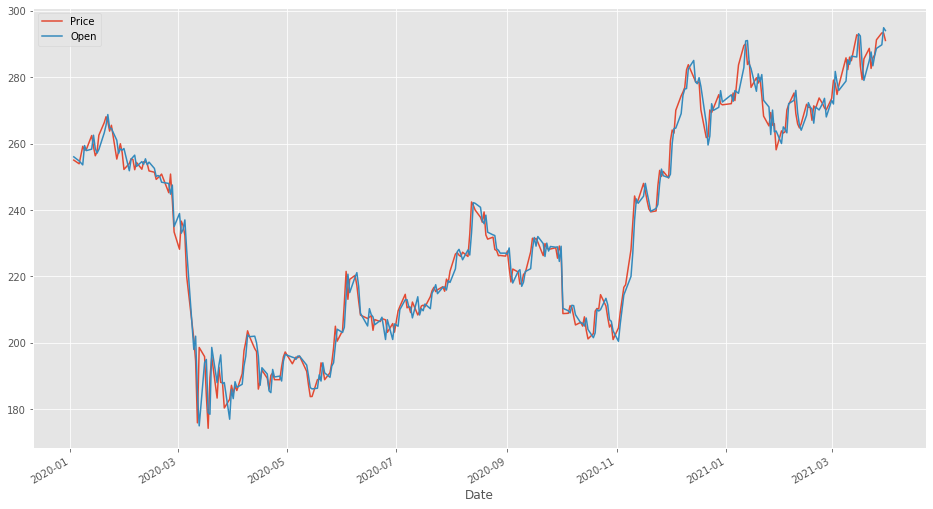

In [10]:
df[['Price', 'Open']].plot()

From visual inspection price time series has no stationarity nor seasonality. I will later do decomposition to prove it.

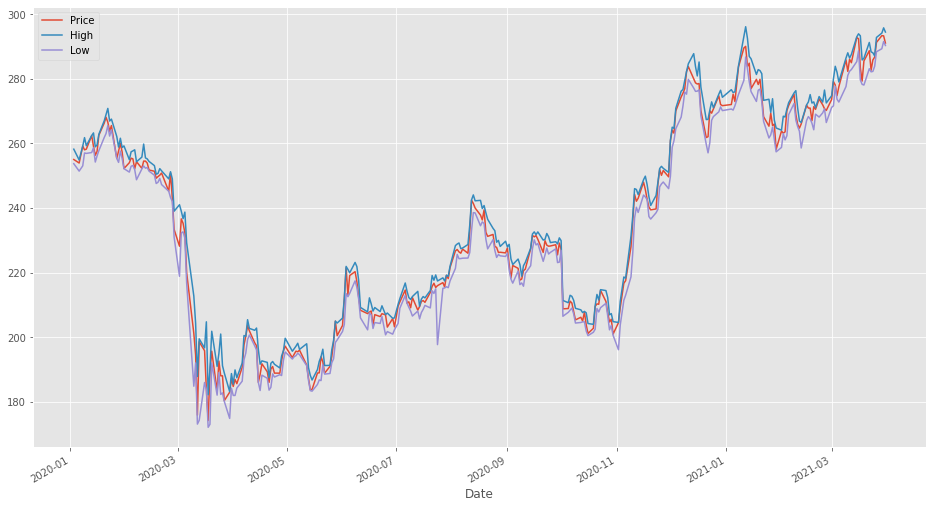

In [11]:
df[['Price','High', 'Low']].plot()
plt.show()

<AxesSubplot:xlabel='Date'>

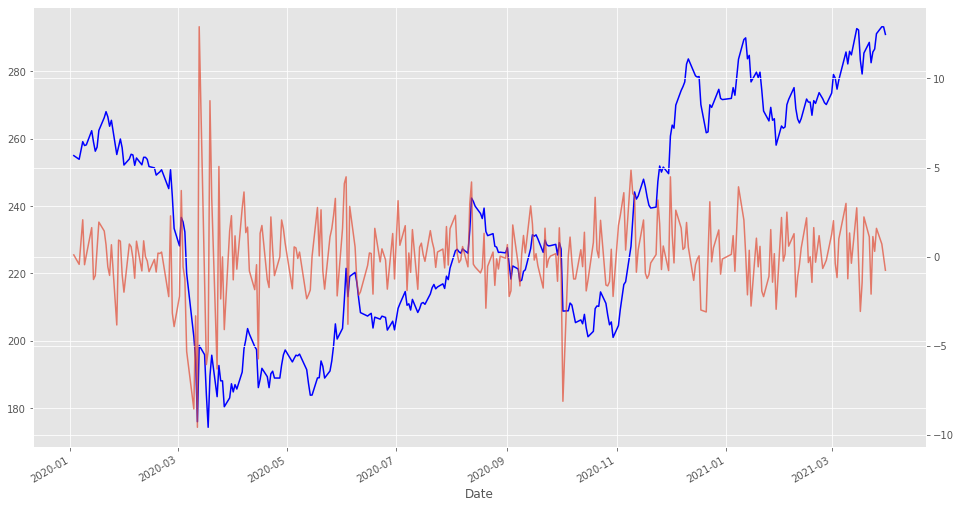

In [12]:
fig, ax1 = plt.subplots()
df['Price'].plot(ax = ax1, color = 'blue')

ax2 = ax1.twinx()
df['Change %'].plot(ax = ax2, alpha = 0.7)

Next I plot all stocks on one chart to investigate if there is a common trend among them. As all of them have different prices, I scaled them using min-max scaler. 

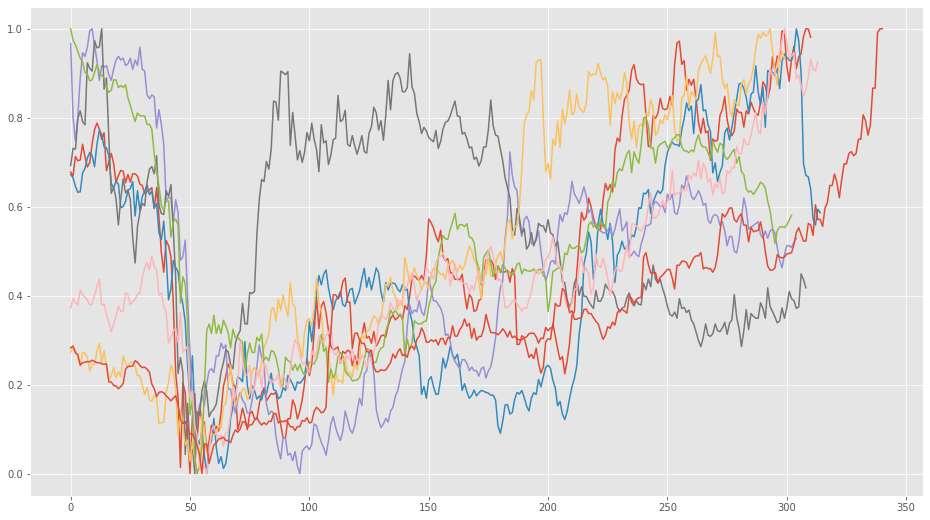

In [13]:
for k in dic_df.keys():
    scaler = MinMaxScaler()
    y_t = scaler.fit_transform(np.array(dic_df[k][['Price']]))
    plt.plot(y_t)

plt.show()

As we can see from the chart above, there is no one common trend among stocks. Some of them decrease when COVID pandemic starts in March 2020, while others increase in price in same time period.

## Sberbank Rossii PAO
### Decomposition
Next, I wanted to see if there are any seasonal fluctutions in time series. Decomposition process should be performed for it, which means breakin the data into three components:
- **Trend:** The overall direction that the data is travelling in (like upwards or downwards)
- **Seasonality:** Cyclical patterns in the data
- **Noise:** The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. 

For decomposition process to happen, time series data must have a defined frequency. However our data does not have any frequency defined, so I will need to set it.

In [14]:
print(f'Frequency of the dataframe: {df.index.freq}')

Frequency of the dataframe: None


I resampled the dataframe for timeseries to have a frequency. The frequency chosen is 'B' which means business days. Stock market is open most of business days so this option is closest to data we have.

In [15]:
# Resample the dataframe with new frequency and assign it to 'df2'
df2 = df.resample('B').mean()

# Print count of NA rows
print(df2.isna().sum())

Price       14
Open        14
High        14
Low         14
Vol.        14
Change %    14
dtype: int64


As we can see above, 14 new rows were added. I populated these NAN values using forward fill method, because the price of stock on added day is equal to previous day price. Only issue here `Volume` and `Change %` columns, they should be equal to '0'.

In [16]:
df2.fillna(method = 'ffill', inplace = True)

I used `seasonal_decompose()` function of `statsmodels` package to quantify the component parts in our data. I chose 'multiplicative' model for decomposition as I believe that fluctuations that happen in price is usually certain percentage of the stock price, not a fixed value. From this point I will only work with `Price` column.

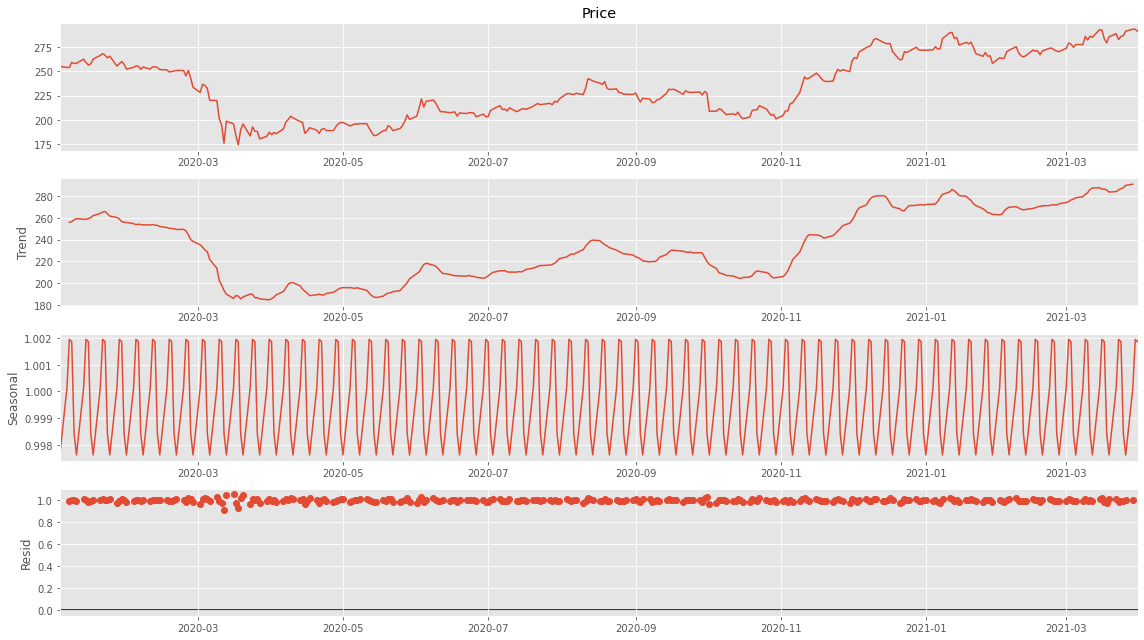

In [17]:
decomposition = seasonal_decompose(df2['Price'], model='multiplicative')
decomposition.plot()
plt.show()

## SARIMAX ARIMA

To apply Arima model, the data must be checked for stationarity. Time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance. However, after performing visual inspection of the data, the mean of the time series is not constant - it fluctuates.
There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the p-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [18]:
# Set y value
y = df['Price']

In [19]:
def get_kpss_stat(y):
    kpss_result = kpss(y)

    print(f'KPSS Statistic: {kpss_result[0]}')
    print(f'p-value: {kpss_result[1]}')
    print(f'num lags: {kpss_result[2]}')

get_kpss_stat(y)

KPSS Statistic: 1.2484688523760854
p-value: 0.01
num lags: 11


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data.

So we need to do some transforming to get a constant mean. It can be done by differencing our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

I used the `diff()` function to do this. There is one less value than our existing dataset (since we're taking the difference between the existing values).

<AxesSubplot:xlabel='Date'>

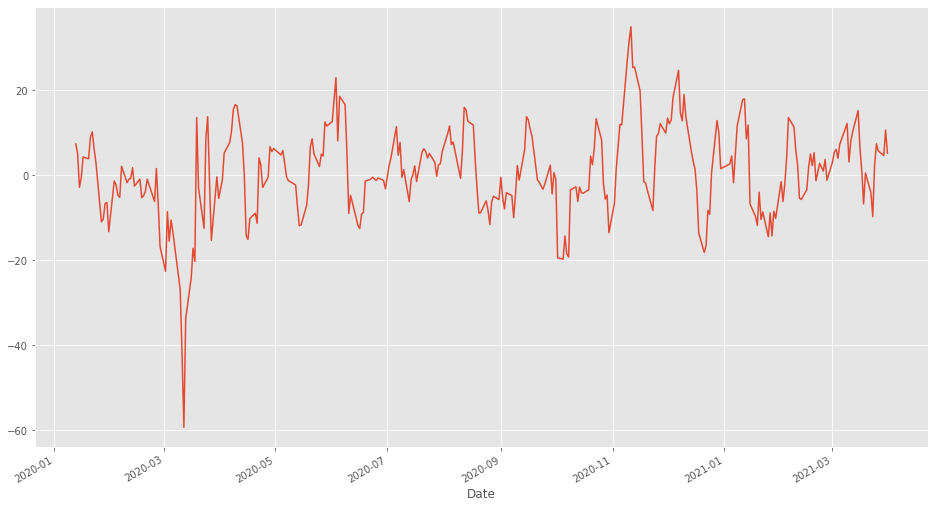

In [20]:
y_d = y.diff(5).dropna()
y_d.plot()

Now we can check p-value again to cinfirm that our data turned stationary after manipulations.

In [21]:
get_kpss_stat(y_d)

KPSS Statistic: 0.3532849977964293
p-value: 0.09729094922567702
num lags: 9


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary. Now I split dataset into training and testing based on year, 2020 data is training set while 2021 data is test set.

In [22]:
train_len = (y.index.year==2020).sum()
y_train = y[:train_len]
y_test = y[train_len:]


train_len_d = (y_d.index.year==2020).sum()
y_d_train = y_d[:train_len_d]
y_d_test = y_d[train_len_d:]

For choosing proper parameters of SARIMAX model I need parameters `p`, `d` and `q`. To evaluate these parameters, I will feed y-diff values to ARIMA model and calculate their mean squared errors. Following functions calculate optimal p, d and qs.

In [23]:


pdq_arima = auto_arima(y_d_train, trace = True)
p,d,q = pdq_arima.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1602.747, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1890.438, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1625.210, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1730.577, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1888.611, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1626.378, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1626.364, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1590.948, Time=0.61 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1604.528, Time=0.48 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1588.990, Time=0

In [24]:
total_len = y.shape[0]

model = SARIMAX(y_train, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model=model.fit()
y_pred = model.predict(start = train_len, end = total_len-1)
model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05481D+00    |proj g|=  6.79355D-02


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.97333D+00    |proj g|=  1.32704D-01

At iterate   10    f=  2.96538D+00    |proj g|=  1.21973D-02

At iterate   15    f=  2.96199D+00    |proj g|=  3.12761D-02

At iterate   20    f=  2.95970D+00    |proj g|=  1.93855D-02

At iterate   25    f=  2.95582D+00    |proj g|=  4.76423D-02

At iterate   30    f=  2.95431D+00    |proj g|=  9.73089D-03

At iterate   35    f=  2.95263D+00    |proj g|=  2.60999D-02

At iterate   40    f=  2.95120D+00    |proj g|=  1.38607D-02

At iterate   45    f=  2.95070D+00    |proj g|=  6.69866D-03

At iterate   50    f=  2.95000D+00    |proj g|=  7.20462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Price   No. Observations:                  250
Model:             SARIMAX(2, 1, 3)x(2, 1, 3, 5)   Log Likelihood                -737.500
Date:                           Wed, 10 Aug 2022   AIC                           1496.999
Time:                                   22:25:17   BIC                           1535.468
Sample:                                        0   HQIC                          1512.493
                                           - 250                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5063      0.031    -16.425      0.000      -0.567      -0.446
ar.L2         -0.9706      0.034    -28.797      0.000      -1.037      -0.905
ma.L1          0.5688      0.059      9.679      0.000       0.454       0.684
ma.L2          0.9618      0.052     18.662      0.000       0.861       1.063
ma.L3          0.0174      0.048      0.367      0.714      -0.076       0.111
ar.S.L5       -1.3350      0.147     -9.100      0.000      -1.623      -1.047
ar.S.L10      -0.8973      0.128     -7.015      0.000      -1.148      -0.647
ma.S.L5        0.3911      2.958      0.132      0.895      -5.407       6.189
ma.S.L10      -0.4962      4.155     -0.119      0.905      -8.639       7.647
ma.S.L15      -0.8937      2.682     -0.333      0.739      -6.151       4.364
sigma2        22.6021     66.941      0.338      0.736    -108.599     153.803
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                87.43
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.08
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

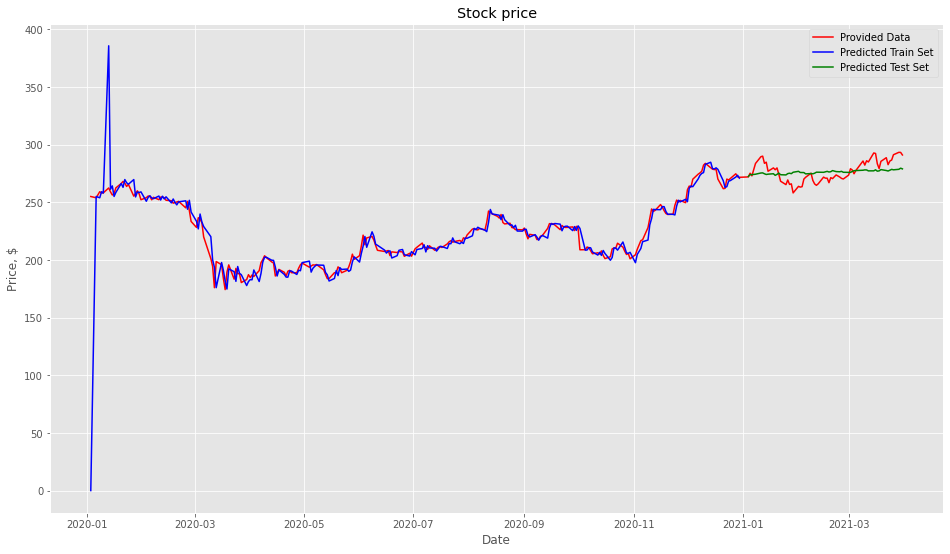

In [25]:
# y_pred2 = model.predict(start = 250, end = 310)
plt.plot(y, color = 'r', label = 'Provided Data')
plt.plot(model.predict(), color = 'b', label = 'Predicted Train Set')

y_pred.index = y_test.index
# plt.plot(y_test[:], color = 'r', label = 'Test Set')
plt.plot(y_pred, color = 'g', label = 'Predicted Test Set')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.title('Stock price')
plt.legend()
plt.show()

In [26]:
# total_len = y.shape[0]

# model = SARIMAX(y_train, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
# model=model.fit()
# y_pred = model.predict(start = 0, end = total_len-1)

# plt.plot(y_train, color = 'r')


# y_pred.index = y.index
# plt.plot(y_test[:], color = 'r')
# plt.plot(y_pred, color = 'b')

# Bollinger Bands
Bollinger Bands belong among popular stock and cryptocurrency trading indicators. Bollinger Bands consist of 3 lines - price moving average for selected window (typically 20 datapoints), upper and lower Bollinger Band.
I used functions described in following articles: [article 1](https://medium.com/codex/algorithmic-trading-with-bollinger-bands-in-python-1b0a00c9ef99) and [article 2](https://tcoil.info/compute-bollinger-bands-for-stocks-with-python-and-pandas/)

In [27]:
def bollinger_bands(df, n):
    # takes dataframe on input
    # n = smoothing length
    
    df['mov_avg'] = df['predicted'].rolling(n).mean()
    df['mov_std'] = df['predicted'].rolling(n).std()
    df['upper'] = df['mov_avg'] + 2*df['mov_std']
    df['lower'] = df['mov_avg'] - 2*df['mov_std']
    df.dropna(inplace = True)
    return df

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

def plot_bollinger(df, buy_price, sell_price):
    df['predicted'].plot(label = 'Predicted Price', alpha = 0.3, color = 'blue')
    df['test_set'].plot(label = 'Actual Price', alpha = 0.3, color = 'red')
    df['upper'].plot(label = 'Upper BB', linestyle = '--', linewidth = 1, color = 'black')
    df['mov_avg'].plot(label = 'Middle BB', linestyle = '--', linewidth = 1.2, color = 'grey')
    df['lower'].plot(label = 'Lower BB', linestyle = '--', linewidth = 1, color = 'black')
    plt.scatter(df.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
    plt.scatter(df.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    plt.title('Bollinger Band Strategy Trading Signals')
    plt.legend(loc = 'upper left')
    plt.show()

    
def calculate_return(buy_price, sell_price, y_test):
    i = 0
    result =0
    bp = None
    initial = None
    while i < len(buy_price) and math.isnan(buy_price[i]):
        i+=1
    if i < len(buy_price) and buy_price[i]>0:
        initial = buy_price[i]
    while i < len(buy_price):
        if buy_price[i]>0:
            bp = buy_price[i]
        elif sell_price[i]>0:
            if bp:
                result += (sell_price[i]-bp)
                bp = None
        i+=1
    if initial:
        result = (result/initial)*100
    do_nothing = (y_test[-1]/y_test[0] -1)*100
    print(f'Return using Bollinger Band Strategy is {round(result,2)}%.\nReturn from do nothing strategy is {round(do_nothing,2)}%')

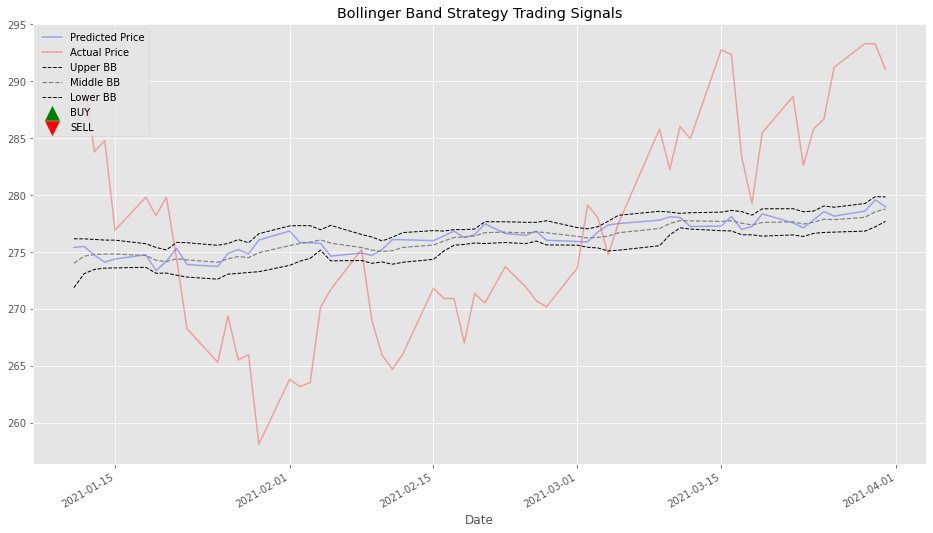

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is 6.99%


In [28]:
df_pred = pd.DataFrame({'test_set':y_test, 'predicted':y_pred})
df_pred = bollinger_bands(df_pred, 5)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['predicted'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)

For Bollinger band moving average I used only 5 days. It is recommended to use 20 days moving average, however for 2021 I have only 60 data points. And if I se 20 of them I will lose 1/3 of my data. I did not want to lose it, so used only 5 days.  
Using bollinger bands strategy on predicted data in period after 2021 did not trigger any buy or sell occurences. It can be due to the fact that my predictions are based only on 2020 data. And after that it will not predict crazy fluctuations. However in real life, I would probably use buy and sell recommendations based on real price and predicted Bollinger Bands. Then my BB graph will look different...

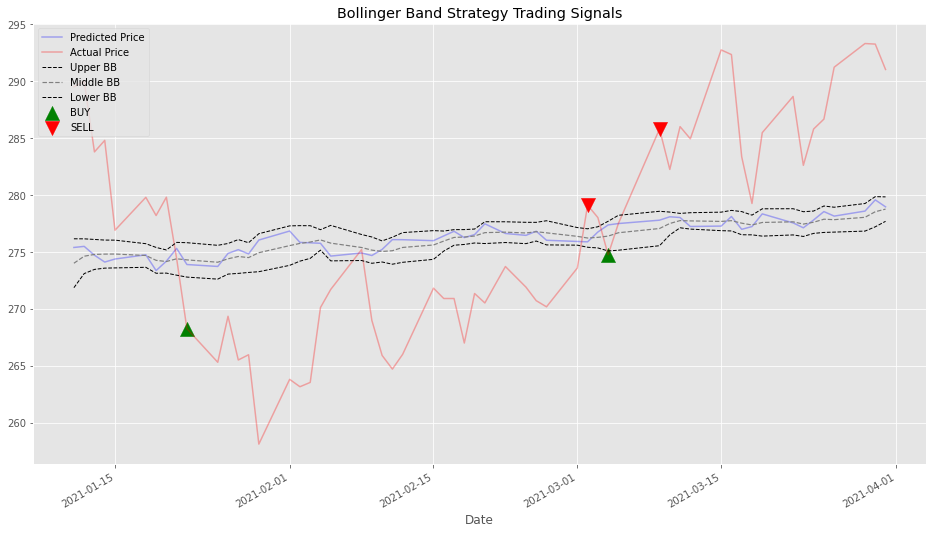

Return using Bollinger Band Strategy is 8.16%.
Return from do nothing strategy is 6.99%


In [29]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['test_set'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)

It is clear from chart above that Bollinger Bands Strategy works and using it predicted return of 8.16%.

Now the same operations should be done to the rest of stocks.

## Koc Holding AS
### Decomposition

Turkey - Koc Holding AS (KCHOL)


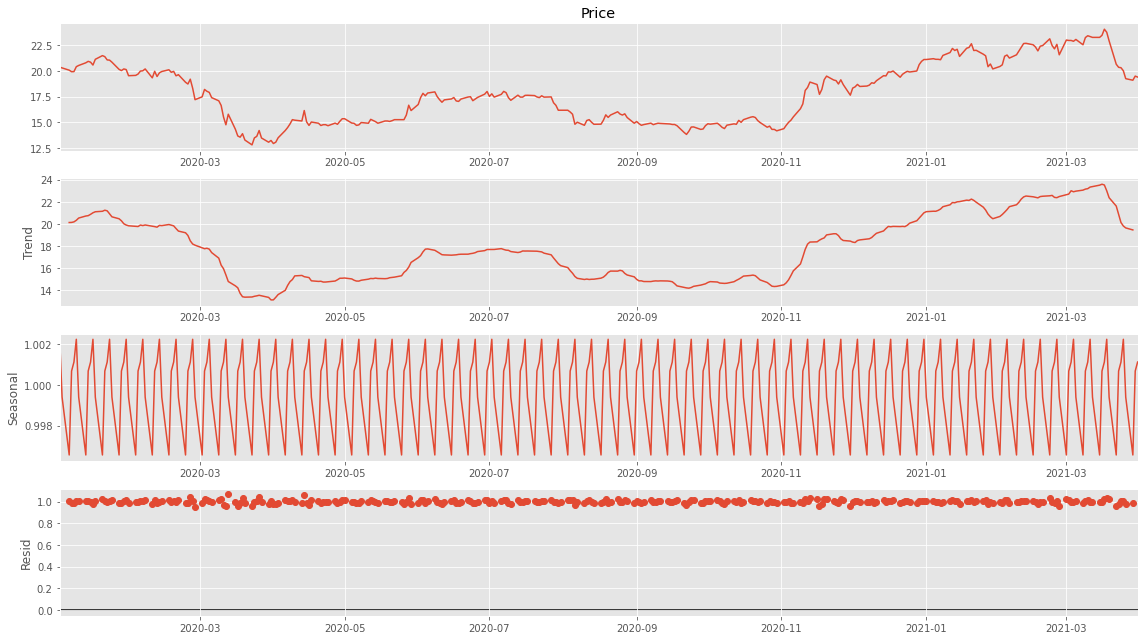

In [30]:
company = list(dic_df.keys())[1]
print(company)
df = dic_df[company]

# Resample the dataframe with new frequency and assign it to 'df2'
df_rs = df.resample('B').mean()
df_rs.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df_rs['Price'], model='multiplicative')
decomposition.plot()
plt.show()

In [31]:
# Set y value
y = df['Price']

# Check for stationarity
get_kpss_stat(y)

KPSS Statistic: 0.8741283096350223
p-value: 0.01
num lags: 11


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data.

In [32]:
# Check for stationarity of difference
y_d = y.diff(5).dropna()
get_kpss_stat(y_d)

KPSS Statistic: 0.18738342179915654
p-value: 0.1
num lags: 10


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

In [33]:
# Split data into train and test sets
train_len = (y.index.year==2020).sum()
y_train = y[:train_len]
y_test = y[train_len:]
y_d_train = y_d[:train_len_d]

In [34]:
# Plotting function
def plot_sarimax(y, y_test, y_pred, model):
    plt.plot(y, color = 'r', label = 'Provided Data')
    plt.plot(model.predict(), color = 'b', label = 'Predicted Train Set')

    y_pred.index = y_test.index
    # plt.plot(y_test[:], color = 'r', label = 'Test Set')
    plt.plot(y_pred, color = 'g', label = 'Predicted Test Set')
    plt.xlabel('Date')
    plt.ylabel('Price, $')
    plt.title('Stock price')
    plt.legend()
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=393.890, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=682.266, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=391.572, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=518.926, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=680.267, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=392.489, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=392.471, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=391.769, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=389.580, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=390.496, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=390.478, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=516.926, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=389.771, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.496 seconds
RUNNING THE L-BFGS-B CODE

        

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.25140D-01    |proj g|=  6.10283D-04

At iterate   20    f=  5.24944D-01    |proj g|=  1.45822D-02

At iterate   25    f=  5.24653D-01    |proj g|=  2.60783D-02

At iterate   30    f=  5.24477D-01    |proj g|=  1.84633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     61      1     0     0   1.008D-05   5.245D-01
  F =  0.52447508741978066     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


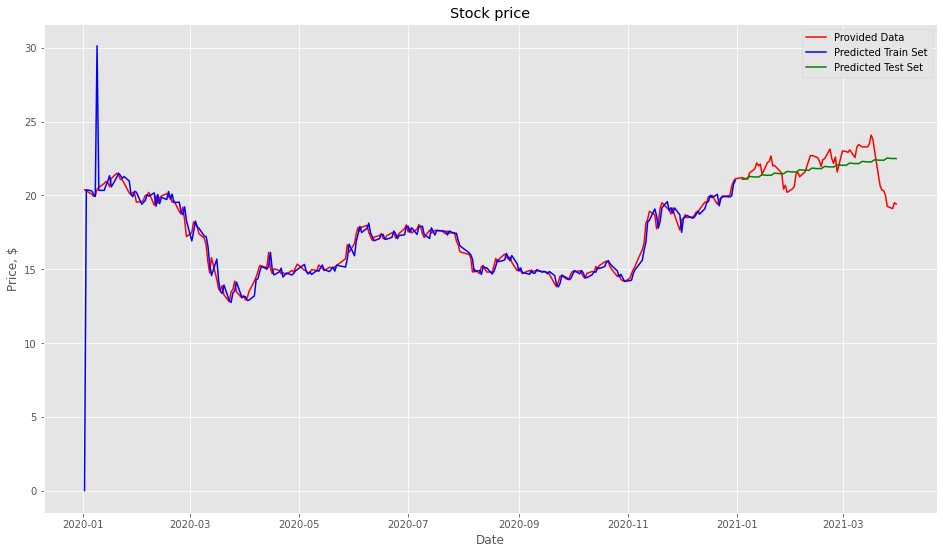

In [35]:
# Find optimal p, d, q parameters
pdq_arima = auto_arima(y_d_train, trace = True)
p,d,q = pdq_arima.order

total_len = y.shape[0]

# Using parameters for SARIMAX train the model and predict
model = SARIMAX(y_train, order = (p,d+1,q+1), seasonal_order= (p,d+1,q+1,5))
model=model.fit()
y_pred = model.predict(start = train_len, end = total_len-1)

# Plot sarimax chart
plot_sarimax(y, y_test, y_pred, model)

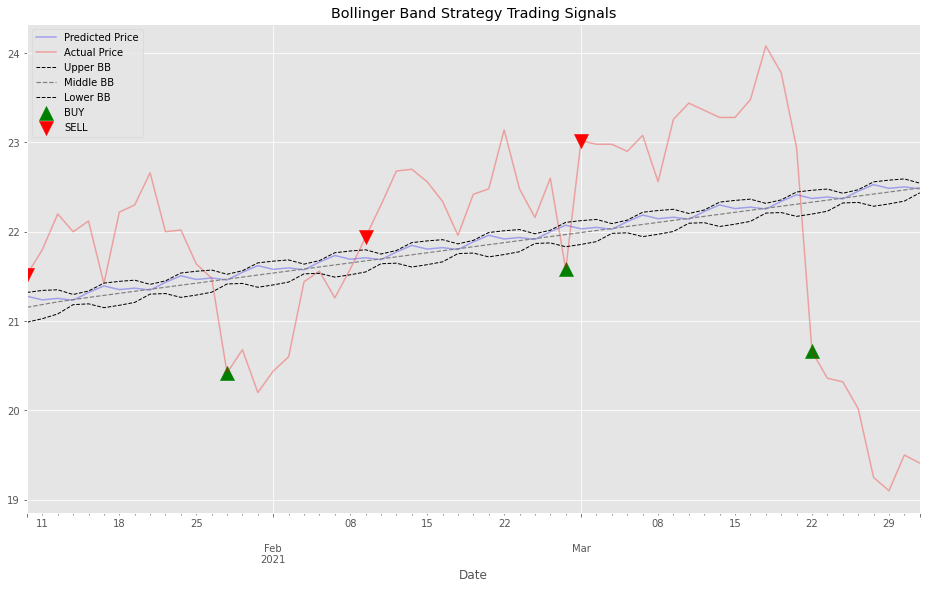

Return using Bollinger Band Strategy is 14.5%.
Return from do nothing strategy is -8.44%


In [36]:
df_pred = pd.DataFrame({'test_set':y_test, 'predicted':y_pred})
df_pred = bollinger_bands(df_pred, 5)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['test_set'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)

## Medinet Nasr Housing

Egypt - Medinet Nasr Housing (M


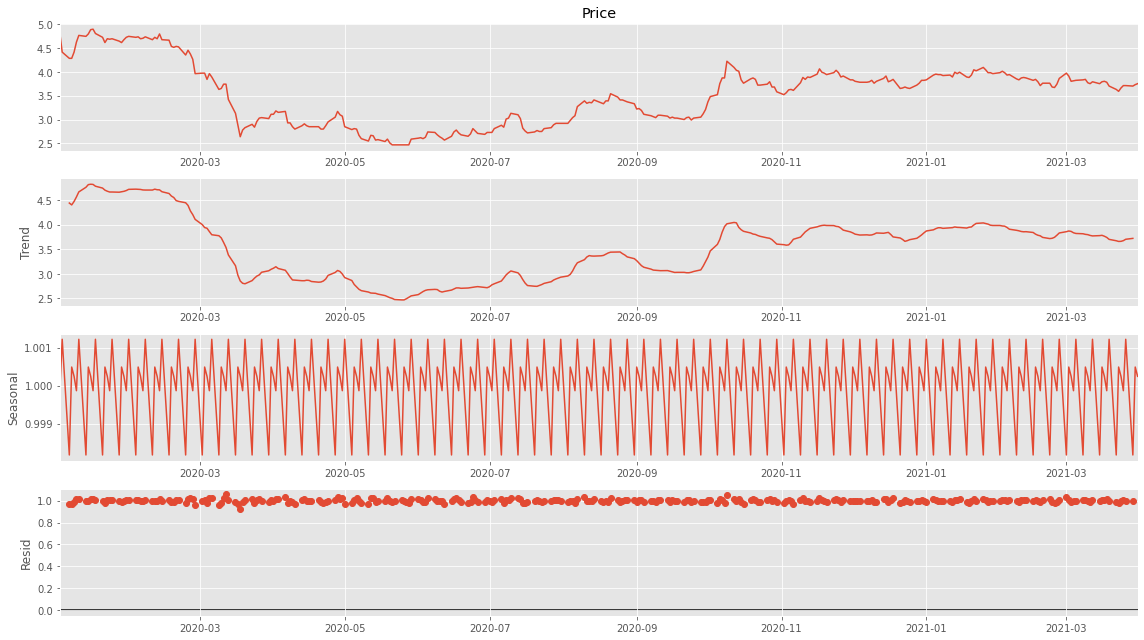

In [37]:
company = list(dic_df.keys())[2]
print(company)
df = dic_df[company]

# Resample the dataframe with new frequency and assign it to 'df2'
df_rs = df.resample('B').mean()
df_rs.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df_rs['Price'], model='multiplicative')
decomposition.plot()
plt.show()

In [38]:
# Set y value
y = df['Price']

# Check for stationarity
get_kpss_stat(y)

# Check for stationarity of difference
y_d = y.diff(5).dropna()
get_kpss_stat(y_d)

KPSS Statistic: 0.48257679247700247
p-value: 0.04559081250517963
num lags: 10
KPSS Statistic: 0.2610567712923486
p-value: 0.1
num lags: 9


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Our p-value greater than 0.05, when we use difference. So we can accept the null hypothesis that our data is stationary

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-363.459, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10.425, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-335.595, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-172.756, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8.996, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-348.411, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-358.410, Time=0.25 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-368.796, Time=0.59 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-365.736, Time=0.48 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-363.885, Time=0.80 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-366.156, Time=0.59 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-387.661, Time=0.53 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-367.758, Time=0.34 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=i

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -9.36251D-01    |proj g|=  9.64998D-01

At iterate   10    f= -9.46870D-01    |proj g|=  5.72299D-02

At iterate   15    f= -9.47890D-01    |proj g|=  1.03132D-01

At iterate   20    f= -9.48198D-01    |proj g|=  1.00683D-02

At iterate   25    f= -9.49110D-01    |proj g|=  6.59404D-02

At iterate   30    f= -9.49455D-01    |proj g|=  5.91566D-02

At iterate   35    f= -9.52602D-01    |proj g|=  5.63305D-02

At iterate   40    f= -9.52861D-01    |proj g|=  2.78206D-02

At iterate   45    f= -9.52895D-01    |proj g|=  6.68285D-04

At iterate   50    f= -9.52896D-01    |proj g|=  7.12947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


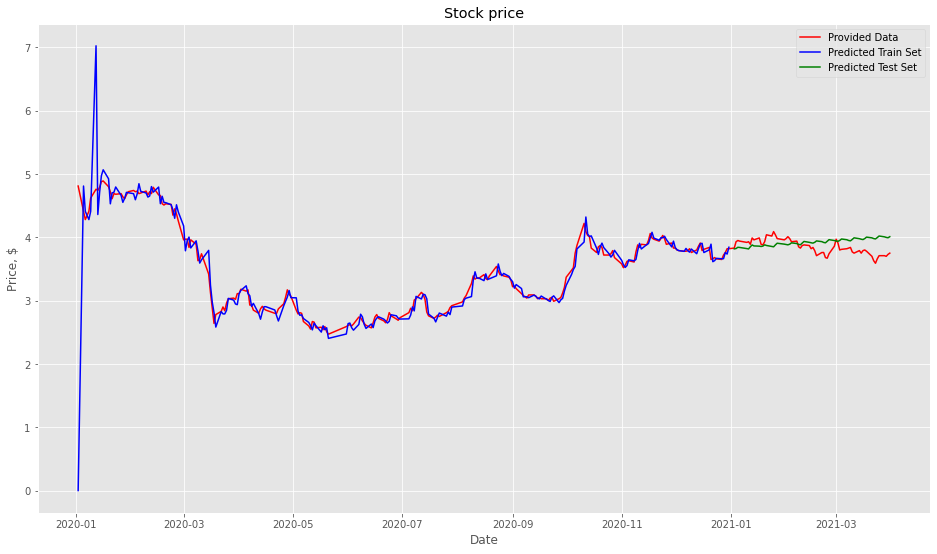

In [39]:
# Split data into train and test sets
train_len = (y.index.year==2020).sum()
y_train = y[:train_len]
y_test = y[train_len:]
y_d_train = y_d[:train_len_d]

# Find optimal p, d, q parameters
pdq_arima = auto_arima(y_d_train, trace = True)
p,d,q = pdq_arima.order

total_len = y.shape[0]

# Using parameters for SARIMAX train the model and predict
model = SARIMAX(y_train, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model=model.fit()
y_pred = model.predict(start = train_len, end = total_len-1)

# Plot sarimax chart
plot_sarimax(y, y_test, y_pred, model)

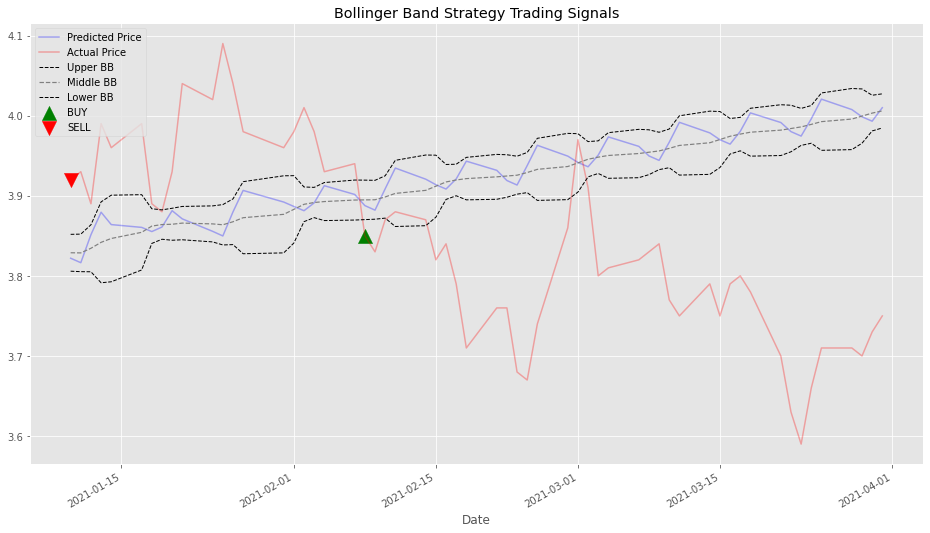

Return using Bollinger Band Strategy is 0.0%.
Return from do nothing strategy is -2.09%


In [40]:
df_pred = pd.DataFrame({'test_set':y_test, 'predicted':y_pred})
df_pred = bollinger_bands(df_pred, 5)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['test_set'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)

## Minerva SABrazil

Brazil - Minerva SABrazil (BEEF


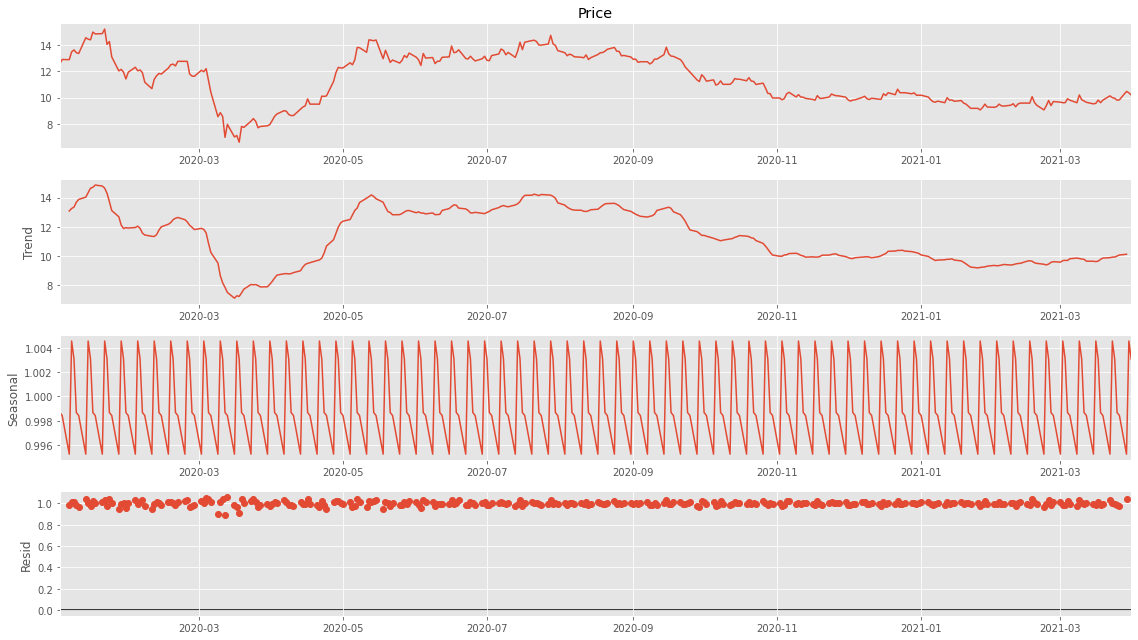

In [41]:
company = list(dic_df.keys())[3]
print(company)
df = dic_df[company]

# Resample the dataframe with new frequency and assign it to 'df2'
df_rs = df.resample('B').mean()
df_rs.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df_rs['Price'], model='multiplicative')
decomposition.plot()
plt.show()

In [42]:
# Set y value
y = df['Price']

# Check for stationarity
get_kpss_stat(y)

# Check for stationarity of difference
y_d = y.diff(5).dropna()
get_kpss_stat(y_d)

KPSS Statistic: 0.7056846703883355
p-value: 0.013028666328333136
num lags: 10
KPSS Statistic: 0.06632071204110133
p-value: 0.1
num lags: 9


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Our p-value greater than 0.05, when we use difference. So we can accept the null hypothesis that our data is stationary

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=413.776, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=688.923, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=429.106, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=546.083, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=687.784, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=430.981, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=430.996, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=405.680, Time=0.52 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=426.420, Time=0.34 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=418.266, Time=0.17 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=403.729, Time=0.47 se

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-


At iterate    5    f=  5.66147D-01    |proj g|=  7.39628D-02

At iterate   10    f=  5.37640D-01    |proj g|=  1.51689D-02

At iterate   15    f=  5.35979D-01    |proj g|=  2.55480D-02

At iterate   20    f=  5.34585D-01    |proj g|=  5.02290D-02

At iterate   25    f=  5.32031D-01    |proj g|=  5.59655D-02

At iterate   30    f=  5.31572D-01    |proj g|=  4.85839D-03

At iterate   35    f=  5.31493D-01    |proj g|=  1.26327D-02

At iterate   40    f=  5.31429D-01    |proj g|=  5.06876D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     44     50      1     0     0   3.951D-05   5.314D-01
  F =  0.531428490487

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


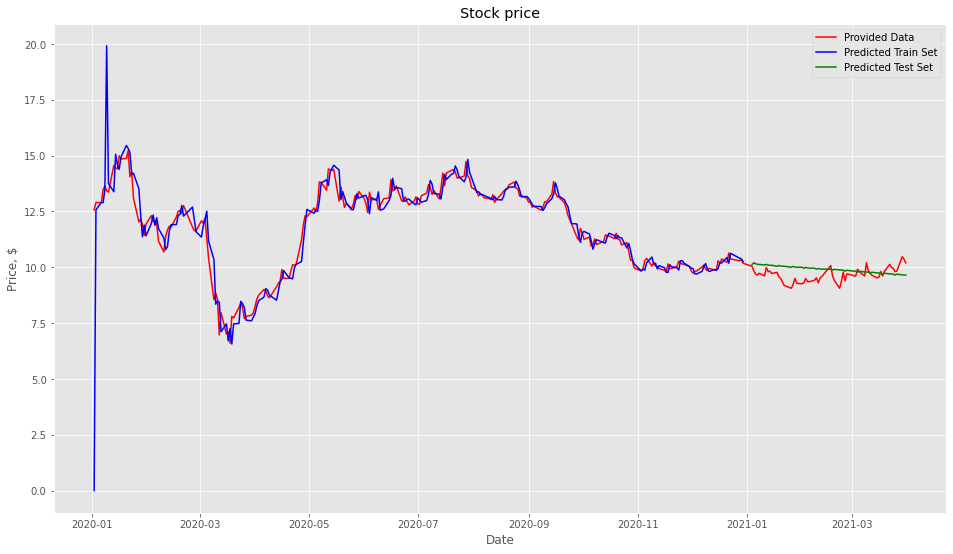

In [43]:
# Split data into train and test sets
train_len = (y.index.year==2020).sum()
y_train = y[:train_len]
y_test = y[train_len:]
y_d_train = y_d[:train_len_d]

# Find optimal p, d, q parameters
pdq_arima = auto_arima(y_d_train, trace = True)
p,d,q = pdq_arima.order

total_len = y.shape[0]

# Using parameters for SARIMAX train the model and predict
model = SARIMAX(y_train, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model=model.fit()
y_pred = model.predict(start = train_len, end = total_len-1)

# Plot sarimax chart
plot_sarimax(y, y_test, y_pred, model)

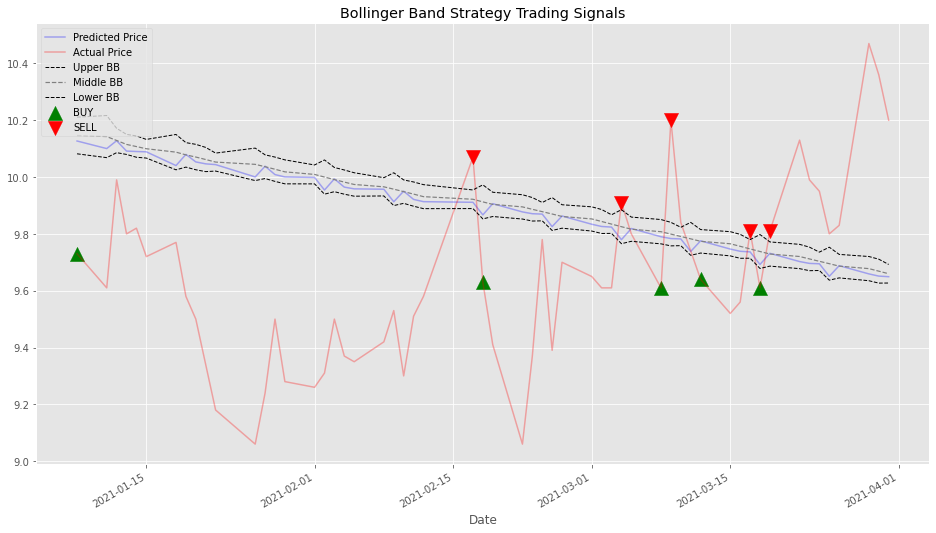

Return using Bollinger Band Strategy is 16.24%.
Return from do nothing strategy is 1.59%


In [44]:
df_pred = pd.DataFrame({'test_set':y_test, 'predicted':y_pred})
df_pred = bollinger_bands(df_pred, 5)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['test_set'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)

## Pampa Energia SA

Argentina - Pampa Energia SA (P


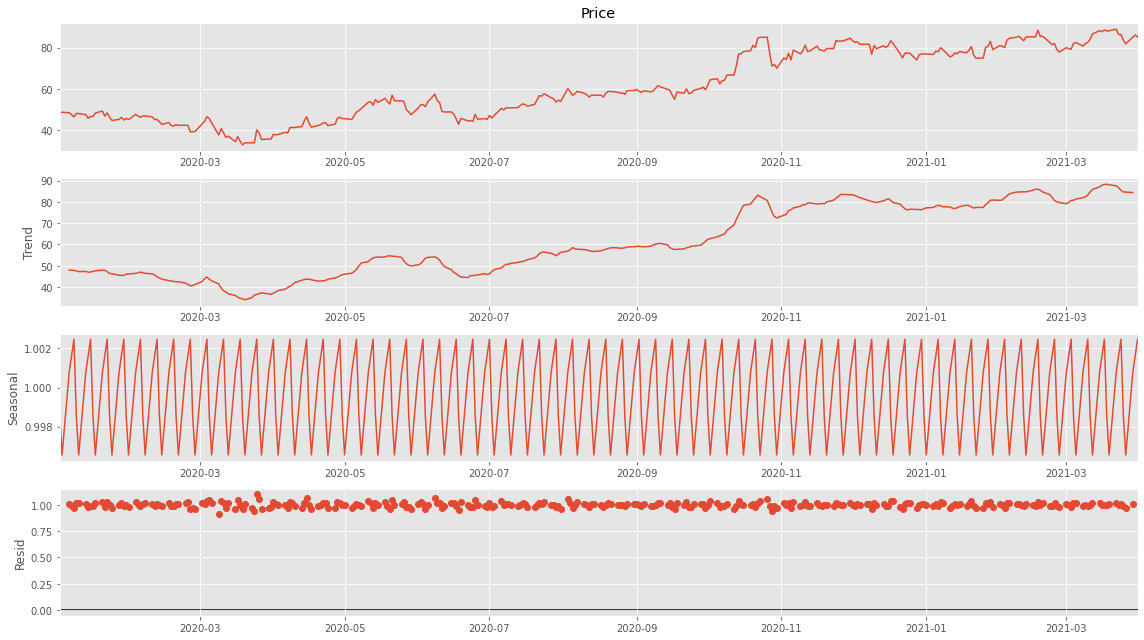

In [45]:
company = list(dic_df.keys())[4]
print(company)
df = dic_df[company]

# Resample the dataframe with new frequency and assign it to 'df2'
df_rs = df.resample('B').mean()
df_rs.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df_rs['Price'], model='multiplicative')
decomposition.plot()
plt.show()

In [46]:
# Set y value
y = df['Price']

# Check for stationarity
get_kpss_stat(y)

# Check for stationarity of difference
y_d = y.diff(5).dropna()
get_kpss_stat(y_d)

KPSS Statistic: 2.6075681971970983
p-value: 0.01
num lags: 10
KPSS Statistic: 0.11102885851767248
p-value: 0.1
num lags: 9


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Our p-value greater than 0.05, when we use difference. So we can accept the null hypothesis that our data is stationary

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1181.933, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1410.857, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1200.107, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1290.050, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1413.479, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1195.877, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1199.928, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1184.421, Time=0.25 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1201.502, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1177.940, Time=0.32 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1216.513, Time=0.27 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1218.872, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=i

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.12971D+00    |proj g|=  2.45037D-02

At iterate   10    f=  2.12255D+00    |proj g|=  6.36162D-03

At iterate   15    f=  2.11972D+00    |proj g|=  2.07692D-02

At iterate   20    f=  2.11880D+00    |proj g|=  9.48951D-04

At iterate   25    f=  2.11875D+00    |proj g|=  7.91753D-04

At iterate   30    f=  2.11861D+00    |proj g|=  2.46605D-03

At iterate   35    f=  2.11854D+00    |proj g|=  1.74904D-03

At iterate   40    f=  2.11853D+00    |proj g|=  2.01880D-04

At iterate   45    f=  2.11853D+00    |proj g|=  1.84017D-04


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



At iterate   50    f=  2.11852D+00    |proj g|=  3.82532D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55      1     0     0   3.825D-05   2.119D+00
  F =   2.1185244138734127     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


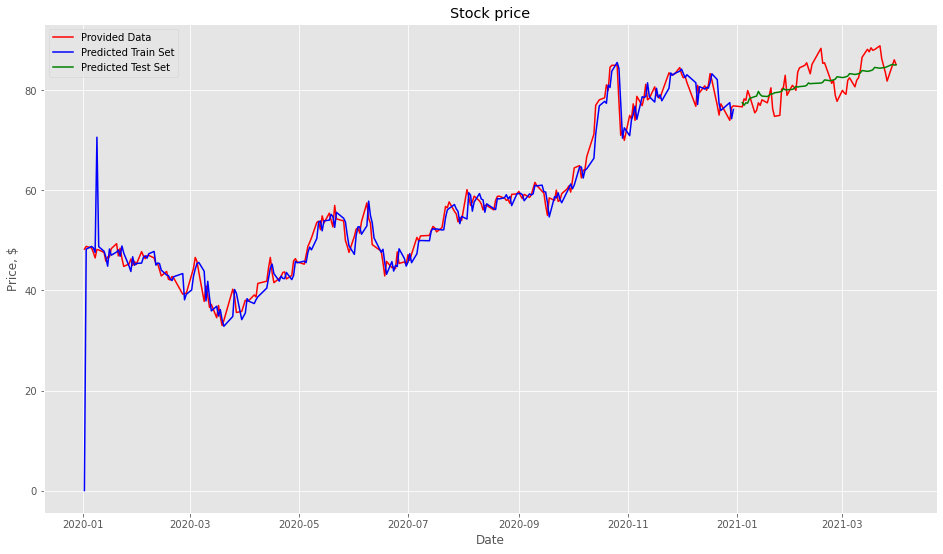

In [47]:
# Split data into train and test sets
train_len = (y.index.year==2020).sum()
y_train = y[:train_len]
y_test = y[train_len:]
y_d_train = y_d[:train_len_d]

# Find optimal p, d, q parameters
pdq_arima = auto_arima(y_d_train, trace = True)
p,d,q = pdq_arima.order

total_len = y.shape[0]

# Using parameters for SARIMAX train the model and predict
model = SARIMAX(y_train, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model=model.fit()
y_pred = model.predict(start = train_len, end = total_len-1)

# Plot sarimax chart
plot_sarimax(y, y_test, y_pred, model)

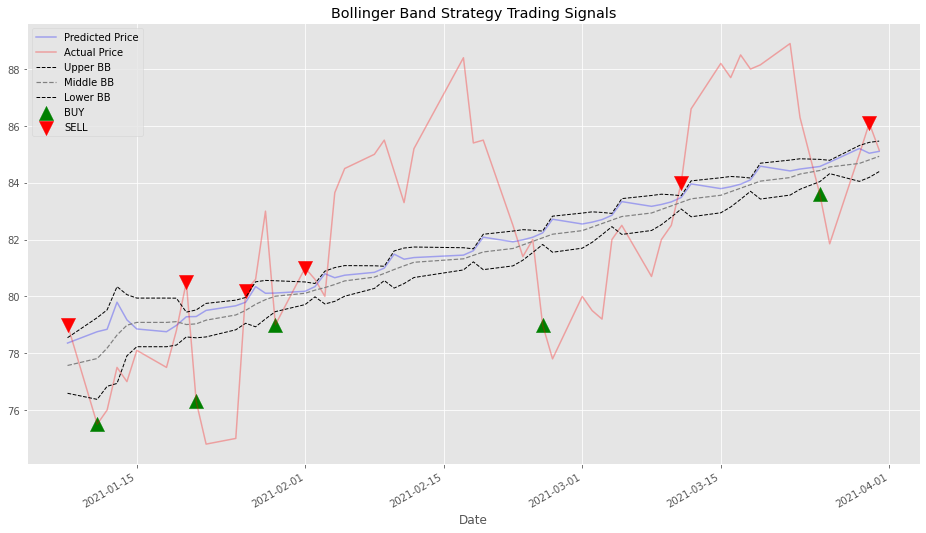

Return using Bollinger Band Strategy is 24.37%.
Return from do nothing strategy is 11.02%


In [48]:
df_pred = pd.DataFrame({'test_set':y_test, 'predicted':y_pred})
df_pred = bollinger_bands(df_pred, 5)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['test_set'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)

## Cementos Argos SA

Colombia - Cementos Argos SA (C


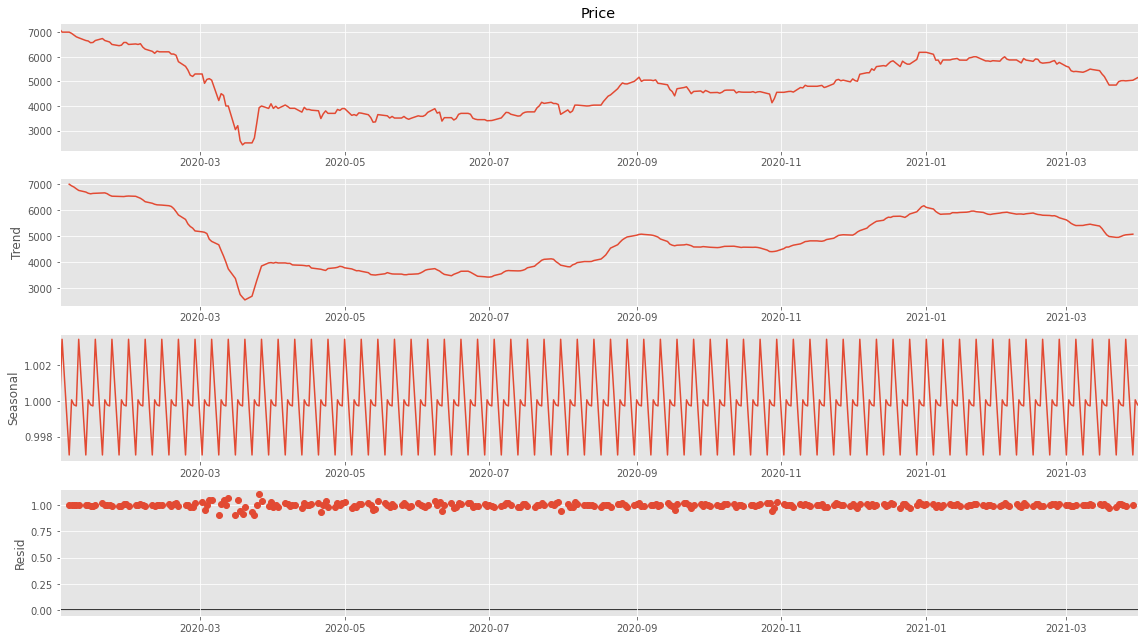

In [49]:
company = list(dic_df.keys())[5]
print(company)
df = dic_df[company]

# Resample the dataframe with new frequency and assign it to 'df2'
df_rs = df.resample('B').mean()
df_rs.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df_rs['Price'], model='multiplicative')
decomposition.plot()
plt.show()

In [50]:
# Set y value
y = df['Price']

# Check for stationarity
get_kpss_stat(y)

# Check for stationarity of difference
y_d = y.diff(5).dropna()
get_kpss_stat(y_d)

KPSS Statistic: 0.6010477209895984
p-value: 0.022541116273672876
num lags: 10
KPSS Statistic: 0.40111973051507055
p-value: 0.07667252995040062
num lags: 9


Our p-value greater than 0.05, when we use difference. So we can accept the null hypothesis that our data is stationary

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3314.623, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3374.762, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3376.696, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3376.707, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3372.774, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3376.745, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3363.387, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3369.595, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3354.941, Time=0.62 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3363.419, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3312.641, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3374.7

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-


At iterate    5    f=  6.45247D+00    |proj g|=  1.23258D-02

At iterate   10    f=  6.45130D+00    |proj g|=  1.22443D-02

At iterate   15    f=  6.44908D+00    |proj g|=  6.01709D-03

At iterate   20    f=  6.44438D+00    |proj g|=  2.37410D-02

At iterate   25    f=  6.36480D+00    |proj g|=  6.21323D-03

At iterate   30    f=  6.36057D+00    |proj g|=  5.63049D-03

At iterate   35    f=  6.36034D+00    |proj g|=  8.10130D-03

At iterate   40    f=  6.35895D+00    |proj g|=  3.72642D-03

At iterate   45    f=  6.35866D+00    |proj g|=  7.08897D-04

At iterate   50    f=  6.35843D+00    |proj g|=  2.02598D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


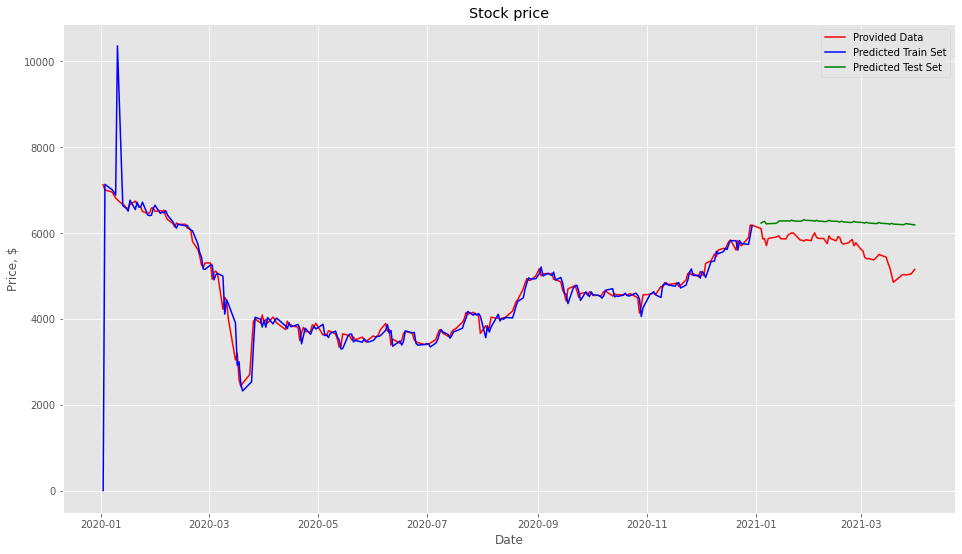

In [51]:
# Split data into train and test sets
train_len = (y.index.year==2020).sum()
y_train = y[:train_len]
y_test = y[train_len:]
y_d_train = y_d[:train_len_d]

# Find optimal p, d, q parameters
pdq_arima = auto_arima(y_d_train, trace = True)
p,d,q = pdq_arima.order

total_len = y.shape[0]

# Using parameters for SARIMAX train the model and predict
model = SARIMAX(y_train, order = (p,d,q), seasonal_order= (p,d,q,5))
model=model.fit()
y_pred = model.predict(start = train_len, end = total_len-1)

# Plot sarimax chart
plot_sarimax(y, y_test, y_pred, model)

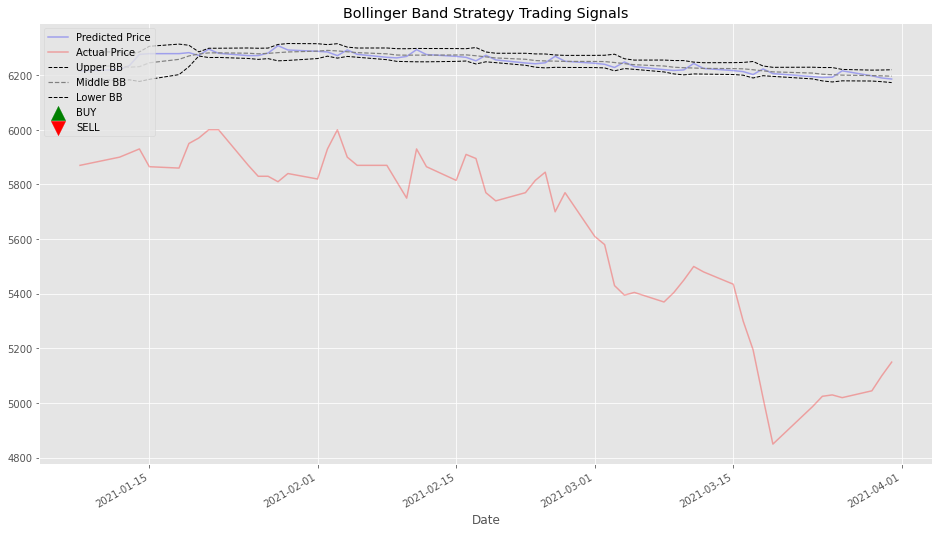

Return using Bollinger Band Strategy is 0%.
Return from do nothing strategy is -15.57%


In [52]:
df_pred = pd.DataFrame({'test_set':y_test, 'predicted':y_pred})
df_pred = bollinger_bands(df_pred, 5)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['test_set'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)

## Impala Platinum

South Africa - Impala Platinum 


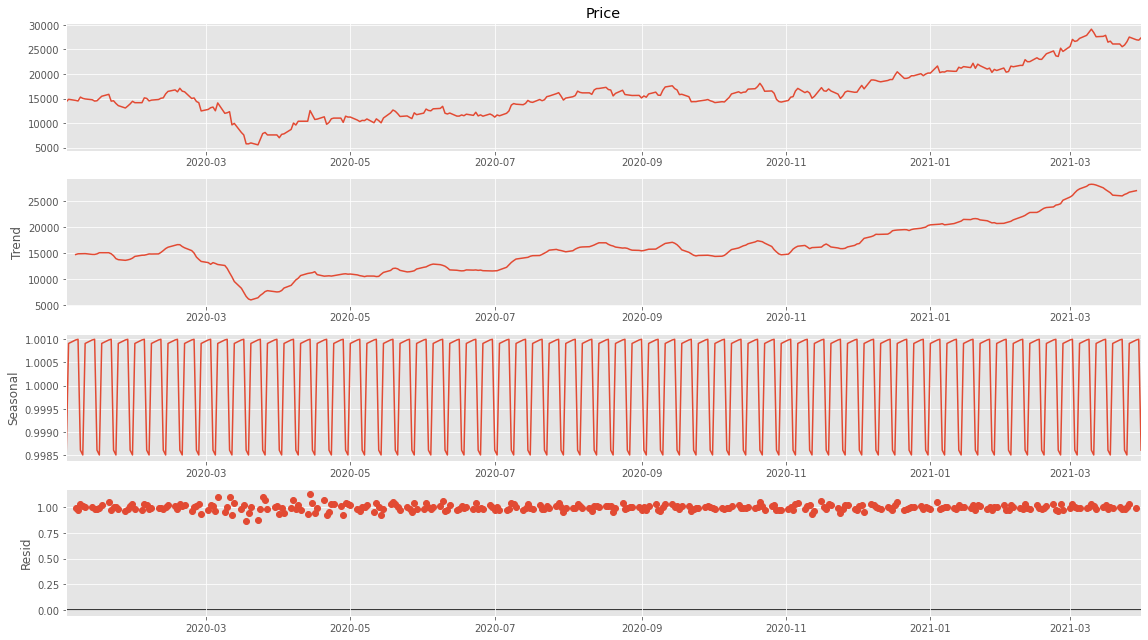

In [53]:
company = list(dic_df.keys())[6]
print(company)
df = dic_df[company]

# Resample the dataframe with new frequency and assign it to 'df2'
df_rs = df.resample('B').mean()
df_rs.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df_rs['Price'], model='multiplicative')
decomposition.plot()
plt.show()

In [54]:
# Set y value
y = df['Price']

# Check for stationarity
get_kpss_stat(y)

# Check for stationarity of difference
y_d = y.diff(5).dropna()
get_kpss_stat(y_d)

KPSS Statistic: 1.952098160917943
p-value: 0.01
num lags: 11
KPSS Statistic: 0.3065358960278652
p-value: 0.1
num lags: 9


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Our p-value greater than 0.05, when we use difference. So we can accept the null hypothesis that our data is stationary

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4020.219, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4286.874, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4056.371, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4143.330, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4285.912, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4057.607, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4051.915, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=4044.982, Time=0.42 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4055.569, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4054.448, Time=0.33 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4018.578, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4055.8

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  7.91389D+00    |proj g|=  6.12715D-03

At iterate   10    f=  7.91296D+00    |proj g|=  7.48975D-03

At iterate   15    f=  7.91247D+00    |proj g|=  1.33405D-03

At iterate   20    f=  7.91224D+00    |proj g|=  5.47428D-03

At iterate   25    f=  7.91191D+00    |proj g|=  1.20715D-03

At iterate   30    f=  7.91179D+00    |proj g|=  6.22806D-03

At iterate   35    f=  7.91131D+00    |proj g|=  1.56160D-02

At iterate   40    f=  7.90724D+00    |proj g|=  3.78312D-02

At iterate   45    f=  7.90371D+00    |proj g|=  3.29727D-02


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,



At iterate   50    f=  7.90279D+00    |proj g|=  7.22040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     69      1     0     0   7.220D-03   7.903D+00
  F =   7.9027949540743148     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


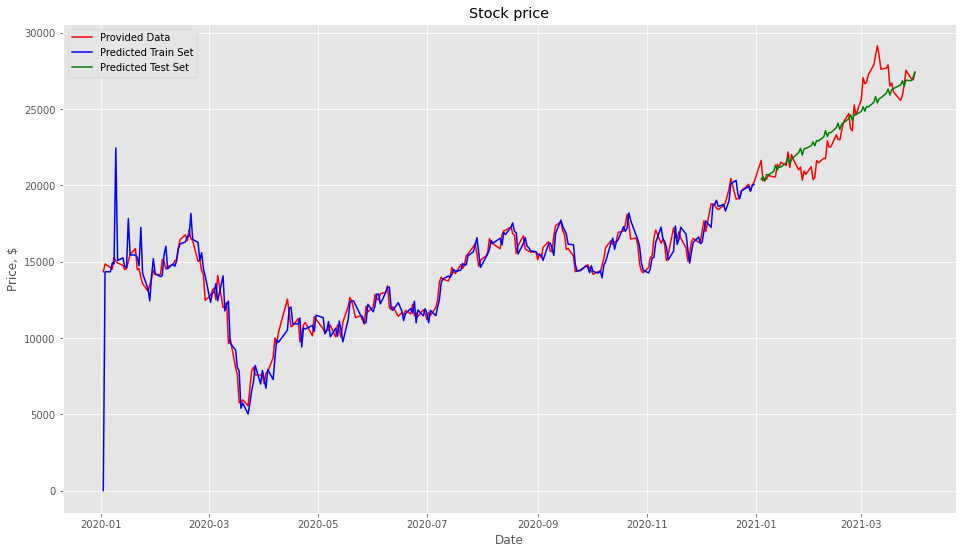

In [55]:
# Split data into train and test sets
train_len = (y.index.year==2020).sum()
y_train = y[:train_len]
y_test = y[train_len:]
y_d_train = y_d[:train_len_d]

# Find optimal p, d, q parameters
pdq_arima = auto_arima(y_d_train, trace = True)
p,d,q = pdq_arima.order

total_len = y.shape[0]

# Using parameters for SARIMAX train the model and predict
model = SARIMAX(y_train, order = (p,d+1,q+1), seasonal_order= (p,d+1,q+1,5))
model=model.fit()
y_pred = model.predict(start = train_len, end = total_len-1)

# Plot sarimax chart
plot_sarimax(y, y_test, y_pred, model)

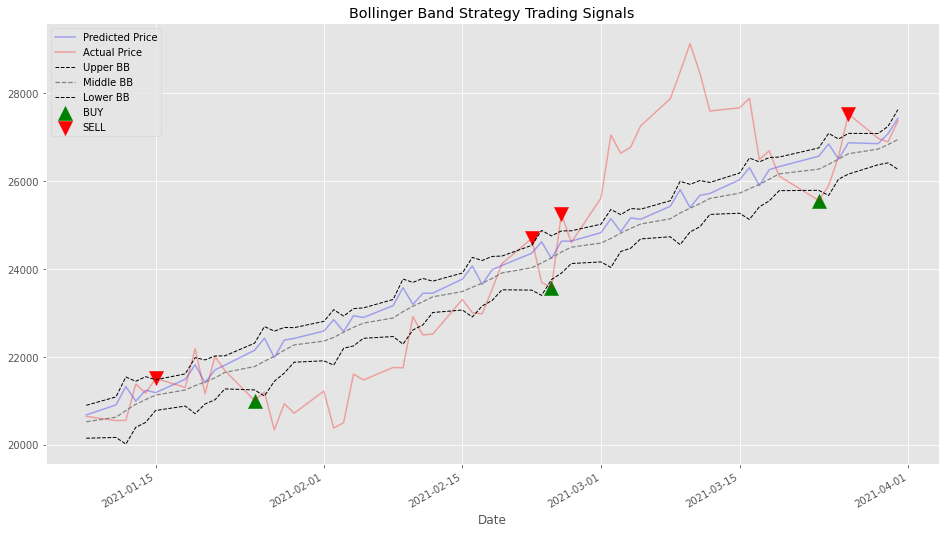

Return using Bollinger Band Strategy is 35.0%.
Return from do nothing strategy is 26.56%


In [56]:
df_pred = pd.DataFrame({'test_set':y_test, 'predicted':y_pred})
df_pred = bollinger_bands(df_pred, 5)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['test_set'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)

## Dongkuk Steel Mil

South Korea - Dongkuk Steel Mil


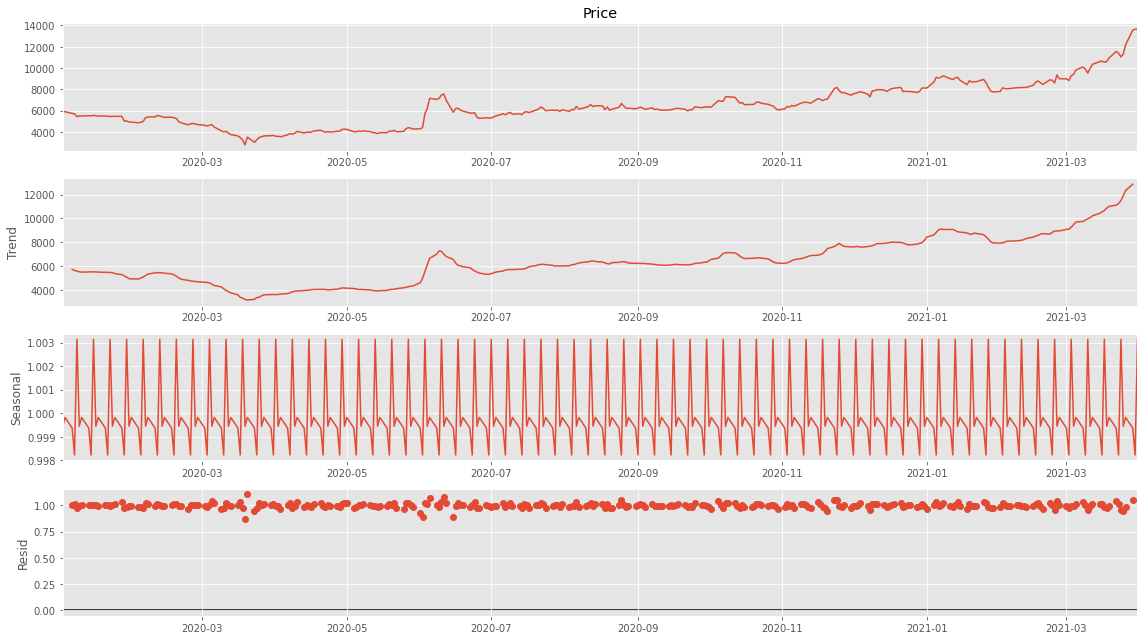

In [57]:
company = list(dic_df.keys())[7]
print(company)
df = dic_df[company]

# Resample the dataframe with new frequency and assign it to 'df2'
df_rs = df.resample('B').mean()
df_rs.fillna(method = 'ffill', inplace = True)

decomposition = seasonal_decompose(df_rs['Price'], model='multiplicative')
decomposition.plot()
plt.show()

In [58]:
# Set y value
y = df['Price']

# Check for stationarity
get_kpss_stat(y)

# Check for stationarity of difference
y_d = y.diff(5).dropna()
get_kpss_stat(y_d)

KPSS Statistic: 2.4296242667743297
p-value: 0.01
num lags: 11
KPSS Statistic: 0.47920605087665036
p-value: 0.04634998854129497
num lags: 10


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Our p-value greater than 0.05, when we use difference. So we can accept the null hypothesis that our data is stationary

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3454.864, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3771.763, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3473.736, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3607.501, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3771.063, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3470.875, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3462.759, Time=0.34 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3463.962, Time=0.51 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3427.574, Time=0.42 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3440.668, Time=0.33 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3425.824, T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.75524D+00    |proj g|=  9.15894D-03

At iterate   10    f=  6.75492D+00    |proj g|=  4.07086D-03

At iterate   15    f=  6.75106D+00    |proj g|=  2.49734D-02

At iterate   20    f=  6.74767D+00    |proj g|=  1.86587D-02

At iterate   25    f=  6.74513D+00    |proj g|=  6.55311D-03

At iterate   30    f=  6.73531D+00    |proj g|=  2.98534D-01

At iterate   35    f=  6.71164D+00    |proj g|=  2.27947D-01

At iterate   40    f=  6.67576D+00    |proj g|=  7.23184D-01

At iterate   45    f=  6.66543D+00    |proj g|=  4.18906D-02


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,



At iterate   50    f=  6.66513D+00    |proj g|=  5.06998D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     81      1     0     0   5.070D-02   6.665D+00
  F =   6.6651313404076271     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


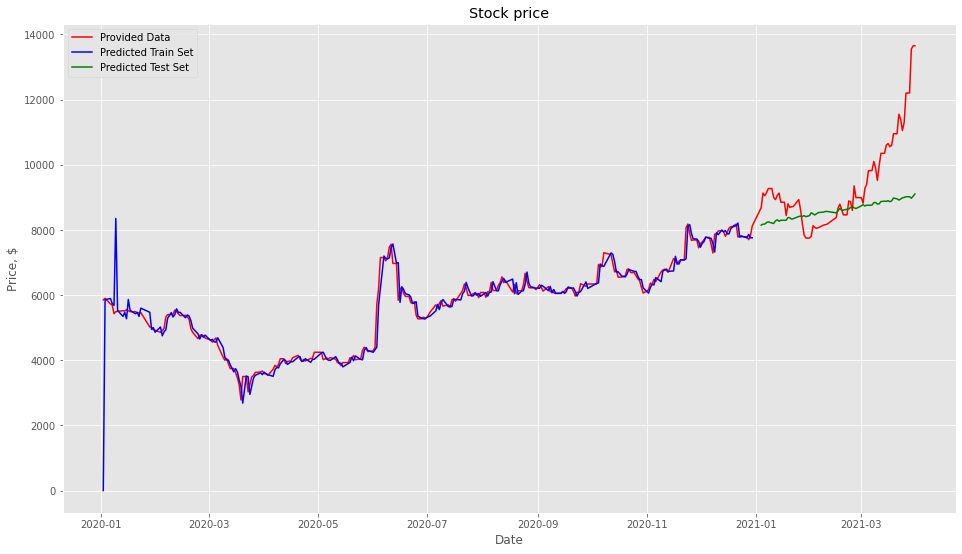

In [59]:
# Split data into train and test sets
train_len = (y.index.year==2020).sum()
y_train = y[:train_len]
y_test = y[train_len:]
y_d_train = y_d[:train_len_d]

# Find optimal p, d, q parameters
pdq_arima = auto_arima(y_d_train, trace = True)
p,d,q = pdq_arima.order

total_len = y.shape[0]

# Using parameters for SARIMAX train the model and predict
model = SARIMAX(y_train, order = (p,d+1,q), seasonal_order= (p,d+1,q,5))
model=model.fit()
y_pred = model.predict(start = train_len, end = total_len-1)

# Plot sarimax chart
plot_sarimax(y, y_test, y_pred, model)

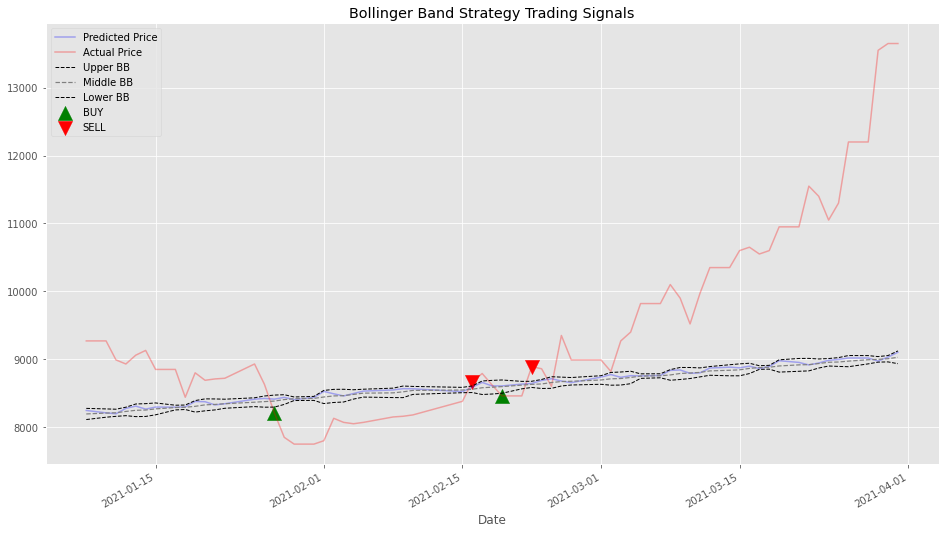

Return using Bollinger Band Strategy is 10.84%.
Return from do nothing strategy is 57.26%


In [60]:
df_pred = pd.DataFrame({'test_set':y_test, 'predicted':y_pred})
df_pred = bollinger_bands(df_pred, 5)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_pred['test_set'], df_pred['lower'], df_pred['upper'])
plot_bollinger(df_pred, buy_price, sell_price)
calculate_return(buy_price, sell_price, y_test)

## Conclusion

Using SARIMAX models I predicted the price of each stock in year 2021 based only on data from 2020. It gave decent results in representing the trend of the stock price movement. Next, I usen Bollinger Bonds Strategy (BBS) to decide to buy or sell the stock. And based on real price I checked if the stock purchases were profitable compared to just buying all of them and holding. Results are given in table below:

| Stock | Return if HOLD | Return with Machine learning Strategy |
|:--------:|:--------:|:--------:|
|Sberbank Rossii PAO|6.99%|8.16%|
|Koc Holding AS|-8.44%|14.5%|
|Medinet Nasr Housing|-2.09%|0%|
|Minerva SABrazil|1.59%|16.24%|
|Pampa Energia SA|11.02%|24.37%|
|Cementos Argos SA|-15.57%|0%|
|Impala Platinum|26.56%|35%|
|Dongkuk Steel Mil|57.26%|10.84%|

As you can see, BBS worked better in all cases but the last one. I think we can consider the strategy successful, as the case where BBS performed worse had abnormal growth of price which was impossible to predict from historic data.

# Backup Materials

In [ ]:
def evaluate_arima_model(data, arima_order):
    split = int(len(data) * 0.8) 
    train, test = data[0:split], data[split:len(data)]
    past = [x for x in train]
    predictions = list()
 
    for i in range(len(test)):
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    error = mean_squared_error(test, predictions)
    
    return error

# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        bp, bd, bq = p, d, q
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return bp, bd, bq


# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 4)]
d_values = [x for x in range(0, 2)]
q_values = [x for x in range(0, 5)]


# Finally, we can find the optimum ARIMA model for our data.
import warnings
warnings.filterwarnings("ignore")

# p, d, q = evaluate_models(y_d_train, p_values, d_values, q_values)

## Train test split

In [61]:
df = dic_df[list(dic_df.keys())[0]]
df_train = df[df.index.year==2020]
df_test = df[df.index.year==2021]

print(f'Shape of original dataframe: {df.shape}')
print(f'Shape of train dataframe: {df_train.shape}')
print(f'Shape of test dataframe: {df_test.shape}')

Shape of original dataframe: (311, 6)
Shape of train dataframe: (250, 6)
Shape of test dataframe: (61, 6)


## LSTM

In [62]:
X_train, X_test = df_train[['Price']], df_test[['Price']]


scaler = MinMaxScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:10]

array([[0.73752969],
       [0.72748036],
       [0.77544308],
       [0.76484561],
       [0.76667276],
       [0.8051343 ],
       [0.77452951],
       [0.74949753],
       [0.76046044],
       [0.80604787]])

In [63]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 5
n_features = 1

generator_train = TimeseriesGenerator(X_train_scaled, X_train_scaled, length=n_input, batch_size=1)
generator_test = TimeseriesGenerator(X_test_scaled, X_test_scaled, length=n_input, batch_size=1)

In [65]:
X,y = generator_train[0]

print(f'X: \n{X}')
print(f'\n y: \n {y}')

X: 
[[[0.73752969]
  [0.72748036]
  [0.77544308]
  [0.76484561]
  [0.76667276]]]

 y: 
 [[0.8051343]]


In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.initializers import he_uniform

In [87]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences = True, input_shape=(n_input, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1, kernel_initializer = he_uniform()))
model.compile(optimizer='adam', loss='mse')

In [88]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 100)            40800     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [89]:
history = model.fit(generator_train,epochs=50)

Epoch 1/50
245/245 [==============================] - 4s 7ms/step - loss: 0.0757
Epoch 2/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0097
Epoch 3/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0083
Epoch 4/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0071
Epoch 5/50
245/245 [==============================] - 3s 10ms/step - loss: 0.0067
Epoch 6/50
245/245 [==============================] - 2s 8ms/step - loss: 0.0057
Epoch 7/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0084
Epoch 8/50
245/245 [==============================] - 2s 6ms/step - loss: 0.0053
Epoch 9/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0038
Epoch 10/50
245/245 [==============================] - 2s 9ms/step - loss: 0.0047
Epoch 11/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0032
Epoch 12/50
245/245 [==============================] - 2s 7ms/step - loss: 0.0039
Epoch 13/50
245/245 [===

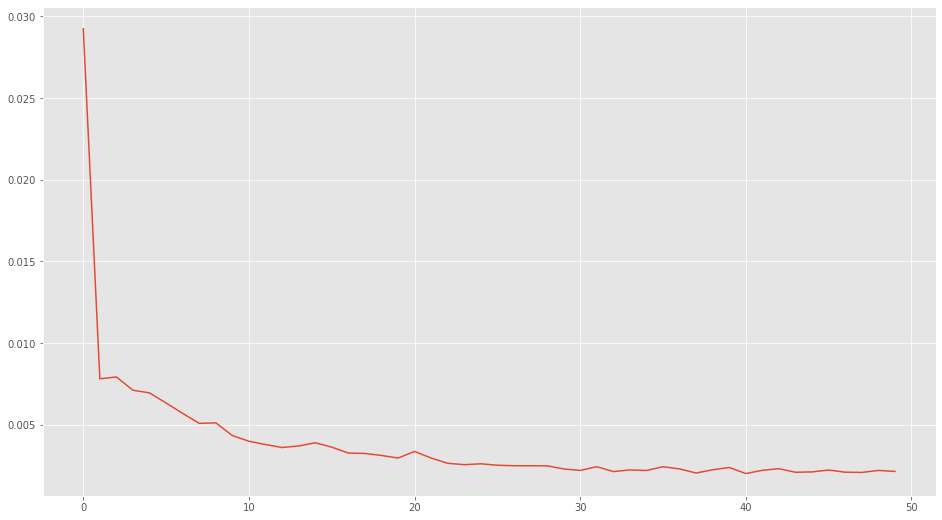

In [90]:
plt.plot(history.history['loss'])
plt.show()

In [ ]:
# y_pred = []

# current = X_train[-n_input:].reshape((1, n_input, n_features))

# for i in range(df_test.shape[0]):
#     predicted = model.predict(current)
    
#     y_pred.append(predicted)
    
#     # current = np.append(current[:,1:,:], [[X_test[i,:]]], axis = 1)
#     current = np.append(current[:,1:,:], [predicted], axis = 1)


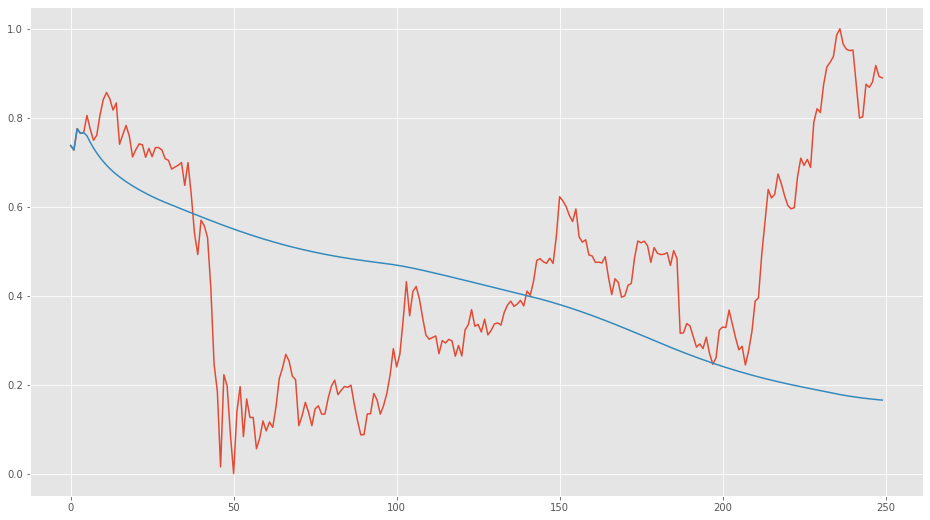

In [91]:
y_pred_train = [X_train_scaled[i] for i in range(n_input)]

current = X_train_scaled[:n_input].reshape((1, n_input, n_features))

for i in range(X_train_scaled.shape[0]- n_input):
    predicted = model.predict(current)
    y_pred_train.append(predicted[0])    
    current = np.append(current[:,1:,:], [predicted], axis = 1)

plt.plot(X_train_scaled)
plt.plot(y_pred_train)
# y_pred_train_np = np.array(y_pred_train)[:,:]
# # y_pred_train_unscaled = scaler.inverse_transform(y_pred_train_np)

# df_train['Predicted'] = y_pred_train_unscaled

# df_train[['Price', 'Predicted']].plot(alpha = 0.5)
# plt.ylim([0,400])

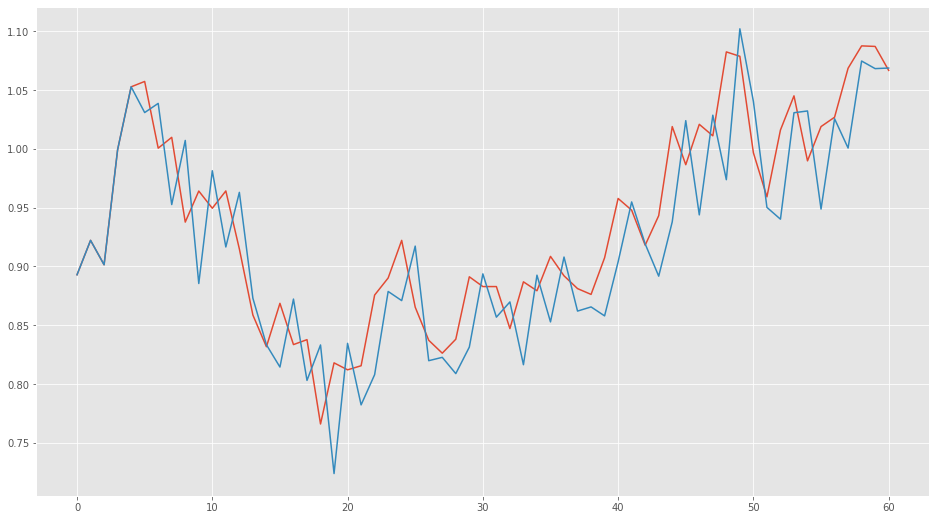

In [92]:
# from generator
y_pred_test = [X_test_scaled[i] for i in range(n_input)]

for i in range(X_test_scaled.shape[0]-n_input):
    current = generator_test[i][0]
    predicted = model.predict(current)
    y_pred_test.append(predicted[0])    

plt.plot(X_test_scaled)
plt.plot(y_pred_test)

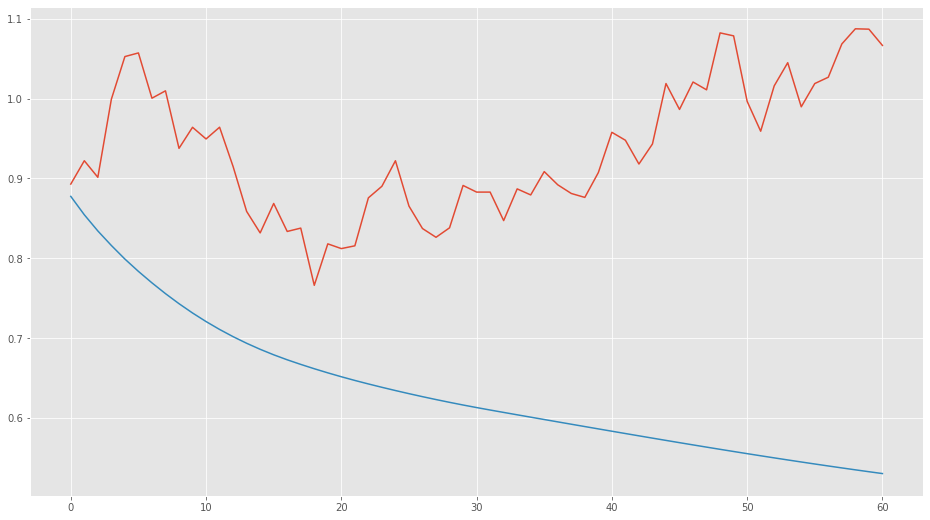

In [93]:
# y_pred_test = [X_test_scaled[i] for i in range(n_input)]
# current = X_test_scaled[:n_input].reshape((1, n_input, n_features))
y_pred_test = []
current = X_train_scaled[-n_input:].reshape((1, n_input, n_features))


for i in range(X_test_scaled.shape[0]):
    predicted = model.predict(current)
    y_pred_test.append(predicted[0])    
    current = np.append(current[:,1:,:], [predicted], axis = 1)

# y_pred_test_np = np.array(y_pred_test)[:,:]
# y_pred_test_unscaled = scaler.inverse_transform(y_pred_test_np)

# # df_test_plot = df_test.iloc[n_input:,:]
# df_test['Predicted'] = y_pred_test_unscaled

# df_test[['Price', 'Predicted']].plot(alpha = 0.5)    

plt.plot(X_test_scaled)
plt.plot(y_pred_test)

In [ ]:
print()

In [ ]:
plt.plot(df_train['Price'])
plt.plot(df_test[['Price', 'Predicted']])    
# plt.ylim([0,400])

In [ ]:
# y_pred_np = np.array(y_pred)[:,:,0]
# y_pred_unscaled = scaler.inverse_transform(y_pred_np)

# df_test['Predicted'] = y_pred_unscaled

# df_test[['Price', 'Predicted']].plot()

In [ ]:
y_pred = []

current = X_train[:n_input].reshape((1, n_input, n_features))

for i in range(df_train.shape[0]-n_input):
    predicted = model.predict(current)
    
    y_pred.append(predicted)
    
    # current = np.append(current[:,1:,:], [[X_test[i,:]]], axis = 1)
    current = np.append(current[:,1:,:], [predicted], axis = 1)

y_pred_np = np.array(y_pred)[:,:,0]
y_pred_unscaled = scaler.inverse_transform(y_pred_np)

df_train['Predicted'] = y_pred_unscaled

df_train[['Price', 'Predicted']].plot()

In [ ]:
X_train, X_test = df_train[['Change %']], df_test[['Change %']]


# scaler = MinMaxScaler()

# scaler.fit(X_train)
# X_train = scaler.transform(X_train)

generator = TimeseriesGenerator(X_train, X_train, length=n_input, batch_size=1)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(generator,epochs=30)

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
y_pred = []

current = X_train[-n_input:].reshape((1, n_input, n_features))

for i in range(df_test.shape[0]):
    predicted = model.predict(current) 
    y_pred.append(predicted)
    current = np.append(current[:,1:,:], [predicted], axis = 1)

y_pred_np = np.array(y_pred)[:,:,0]
y_pred_unscaled = scaler.inverse_transform(y_pred_np)
df_test['Predicted'] = y_pred_unscaled
df_test[['Change %', 'Predicted']].plot()

In [ ]:
for key in dic_df:
    new_df = dic_df[key]
    new_df.sort_index(inplace = True)
    df_train = new_df[new_df.index.year==2020]
    X_train = df_train[['Price']]
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    
    generator = TimeseriesGenerator(X_train, X_train, length=n_input, batch_size=1)
    
    model.fit(generator,epochs=10)